In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from ipywidgets import interact, widgets
import data
import matplotlib.dates as mdates
import warnings
import csv
import deconvolution
import datetime
from covid_forecast import *
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')
matplotlib.rcParams['figure.figsize'] = (10., 6.)
import matplotlib.ticker as mtick
fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)

In [2]:
region='Spain'
N = data.get_population(region)
ifr_val='mean'
ifr = avg_ifr(region,ifr_val)
sigma0s = [2.0,4.0,3.0]
means = [17]
undercount_factors = [1.0,3.0,1.5]
data_dates, cum_cases, cum_deaths = data.load_time_series(region,smooth)
data_start = mdates.date2num(data_dates[0])
nid_low = None
nid_high = None
for sigma0 in sigma0s:
    for mean in means:
        pdf = deconvolution.generate_pdf(8.,mean/8.)
        gamma = np.sum(pdf)/np.sum(pdf*np.arange(len(pdf)))
        beta = sigma0*gamma
        for uf in undercount_factors:
            u0, offset, inferred_data_dates = infer_initial_data(cum_deaths,data_start,ifr,gamma,N)

            no_interv_dates, no_interv_cum_deaths, no_interv_new_infections = \
                no_intervention_scenario(region,pdf,beta,gamma,uf,'03-12-2020',
                                         forecast_length=0,ifr_val=ifr_val)
                                         
            if nid_low is None:
                nid_low = no_interv_cum_deaths.copy()/uf
                nid_high = no_interv_cum_deaths.copy()/uf
            else:
                nid_low = np.minimum(no_interv_cum_deaths/uf,nid_low)
                nid_high = np.maximum(no_interv_cum_deaths/uf,nid_high)

16405.33309417677 335310.7388626133


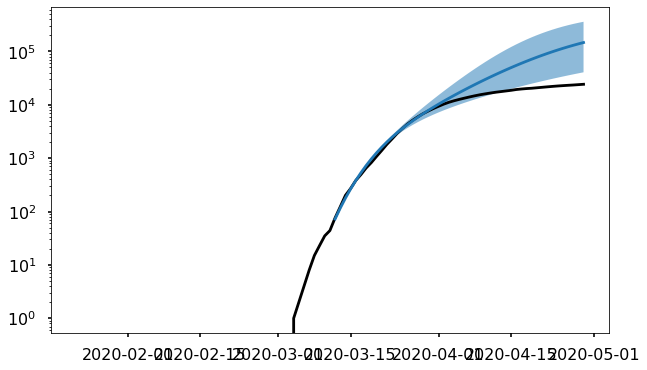

In [3]:
plt.plot_date(data_dates,cum_deaths,'-k')
plt.plot_date(no_interv_dates,no_interv_cum_deaths/uf,'-')
plt.fill_between(no_interv_dates,nid_low,nid_high,alpha=0.5)
ax = plt.gca()
ax.set_yscale('log');
print(nid_low[-1]-cum_deaths[-1],nid_high[-1]-cum_deaths[-1])

67059.42710762892 462567.5842523968


In [7]:
len(no_interv_cum_deaths)

99

In [8]:
len(no_interv_new_infections)

99

(0.1, 10000000.0)

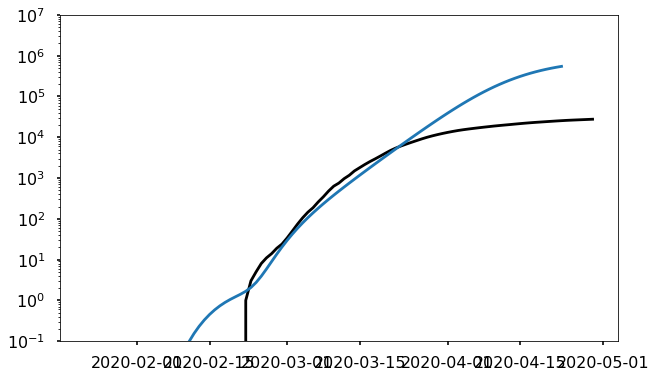

In [118]:
mean = 17
pdf = deconvolution.generate_pdf(8.,mean/8.)
gamma = np.sum(pdf)/np.sum(pdf*np.arange(len(pdf)))
data_dates, cum_cases, cum_deaths = data.load_time_series(region,smooth)
beta = 0.27
gamma = 1./mean
uf = 1.0
data_start = mdates.date2num(data_dates[0])
ifr = avg_ifr(region,'mean')

u0, offset, inf_dates, I, R, delta_I = \
        infer_initial_data(cum_deaths,data_start,ifr,gamma,N,method='deconvolution',extended_output=1,pdf=pdf)

no_interv_dates, no_interv_cum_deaths, no_interv_new_infections = \
    no_intervention_scenario(region,beta,gamma,uf,'02-21-2020',
                             dthresh,dthresh_min,imult=imult,forecast_length=0,ifr_val=ifr_val)

# Assemble hypothetical new infections timeline
new_infections = delta_I.copy()
new_infections[-len(no_interv_new_infections):] = no_interv_new_infections

# Convolve with pdf to get deaths
pdf = pdf[:len(data_dates)]
row = np.zeros(len(pdf)); row[0] = pdf[0]
M0  = linalg.toeplitz(pdf, row);
M0 *= ifr
daily_deaths = M0@new_infections
#daily_deaths = np.convolve(new_infections,pdf*ifr,mode='valid')
cum_no_int_deaths = np.cumsum(daily_deaths)

plt.plot_date(data_dates,cum_deaths,'-k')
plt.plot_date(data_dates[:m],cum_no_int_deaths[:m],'-')
ax = plt.gca()
ax.set_yscale('log');
plt.ylim(1e-1,1e7)

In [110]:
len(pdf)

93

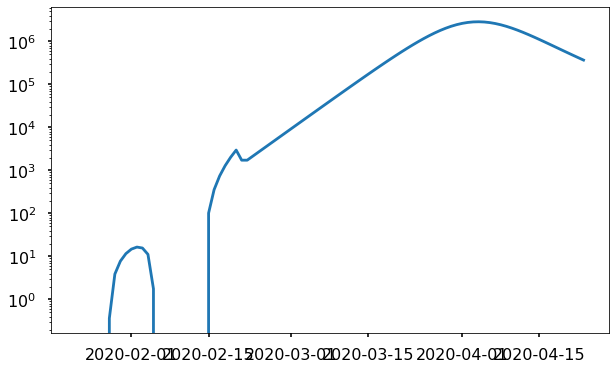

In [111]:
plt.plot_date(data_dates,new_infections,'-')
ax = plt.gca()
ax.set_yscale('log');

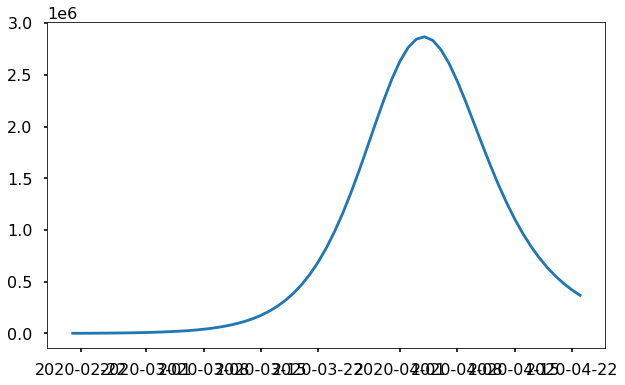

In [112]:
plt.plot(no_interv_dates,no_interv_new_infections)

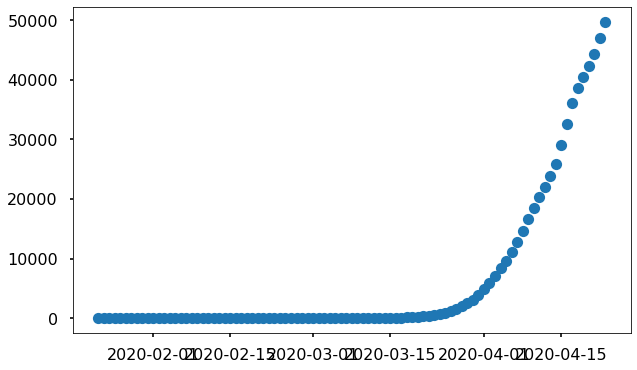

In [14]:
plt.plot_date(data_dates,cum_deaths)
plt.plot_date(data_dates,)

In [6]:
np.diff(no_interv_cum_deaths)

array([  584.50254638,   710.03839788,   861.47587113,  1043.58768588,
        1261.83340481,  1522.30031143,  1831.61493472,  2196.76393987,
        2624.79457203,  3122.36599621,  3695.13160483,  4346.95237974,
        5078.97545827,  5888.65967776,  6768.88446386,  7707.32528418,
        8686.29638976,  9683.22774863, 10671.84725592, 11623.9938567 ,
       12511.83095871, 13310.11612199, 13998.15707935, 14561.15792203,
       14990.80553472, 15285.1124061 , 15447.66552664, 15486.50179387,
       15412.83599513, 15239.82638183, 14981.5005294 , 14651.90214293,
       14264.47043592, 13831.63184542, 13364.56762822, 12873.11622248,
       12365.7717415 , 11849.74598768, 11331.06847652, 10814.70571312,
       10304.68669405,  9804.22612007,  9315.84016233,  8841.45200661,
        8382.48599679])

In [7]:
no_interv_cum_deaths

array([6.90000000e+01, 6.53502546e+02, 1.36354094e+03, 2.22501682e+03,
       3.26860450e+03, 4.53043791e+03, 6.05273822e+03, 7.88435315e+03,
       1.00811171e+04, 1.27059117e+04, 1.58282777e+04, 1.95234093e+04,
       2.38703616e+04, 2.89493371e+04, 3.48379968e+04, 4.16068812e+04,
       4.93142065e+04, 5.80005029e+04, 6.76837307e+04, 7.83555779e+04,
       8.99795718e+04, 1.02491403e+05, 1.15801519e+05, 1.29799676e+05,
       1.44360834e+05, 1.59351639e+05, 1.74636752e+05, 1.90084417e+05,
       2.05570919e+05, 2.20983755e+05, 2.36223582e+05, 2.51205082e+05,
       2.65856984e+05, 2.80121455e+05, 2.93953086e+05, 3.07317654e+05,
       3.20190770e+05, 3.32556542e+05, 3.44406288e+05, 3.55737357e+05,
       3.66552062e+05, 3.76856749e+05, 3.86660975e+05, 3.95976815e+05,
       4.04818267e+05, 4.13200753e+05])

In [6]:
177021.53552315832*ifr

1925.0729825874278

In [27]:
no_interv_new_infections[0]

80921.0625620032

In [28]:
ifr

0.01087479541344045

In [19]:
no_interv_dates[0]

Timestamp('2020-03-17 00:00:00', freq='D')